In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, average_precision_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import xgboost
import mlflow

In [49]:
# First we load the preprocessed data
df = pd.read_csv('../data/preprocessing/clean_data_card_transdata.csv')
print("The data has been uploaded successfully!")


The data has been uploaded successfully!


In [50]:
# Split the data: features and target
X = df.drop(columns=['fraud', 'ratio_to_median_purchase_price'])
y = df[['fraud']]


In [51]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

800000 800000
200000 200000


# 1)-Baseline Model

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


============= Random Forest BaseLine Model ==================
f1_score:  0.39955308873351114
recall:  0.3177779051768618
precision_score:  0.5379986411724741
[[177797   4760]
 [ 11900   5543]]


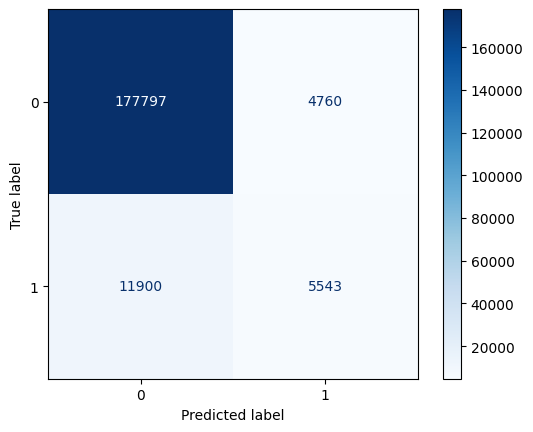

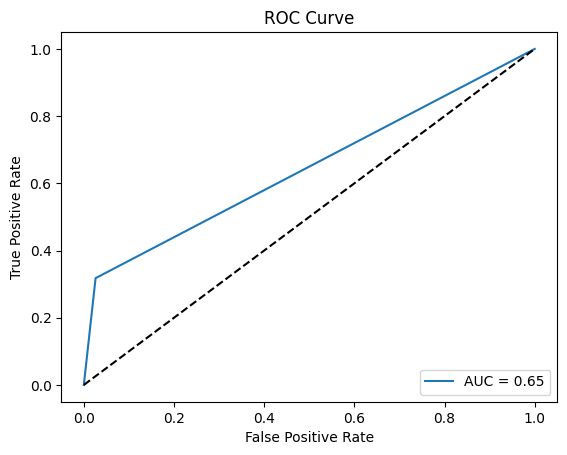

In [52]:
rf_model = RandomForestClassifier(
    n_estimators= 200,
    criterion= 'gini',
    random_state= 42
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

f1_score_rf = f1_score(y_test, y_pred_rf)
recall_score_rf = recall_score(y_test, y_pred_rf)
precision_score_rf = precision_score(y_test, y_pred_rf)

print("============= Random Forest BaseLine Model ==================")
print("f1_score: ", f1_score_rf)
print("recall: ", recall_score_rf)
print("precision_score: ", precision_score_rf)


conf_mat_rf = confusion_matrix(y_test, y_pred_rf)
print(conf_mat_rf)
cmf = ConfusionMatrixDisplay(conf_mat_rf)
cmf.plot(include_values= True, cmap= 'Blues')
plt.show()

# Roc-Auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
auc_score = roc_auc_score(y_test, y_pred_rf)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [53]:
mlflow.set_experiment("Credit Card Fraud Detection")
print("The experiment has been set successfully!")

The experiment has been set successfully!


In [54]:
with mlflow.start_run(run_name="RandomForestBaseLineModel"):
    # Log Baseline Model: RandomForest
    mlflow.log_metrics({
        "f1_score": f1_score_rf,
        "recall": recall_score_rf,
        "precision": precision_score_rf
    })
    mlflow.log_params({
        'n_estimators': 200,
        'criterion': 'gini',
        'random_state': 42
    })
    mlflow.sklearn.log_model(rf_model, "model")

2025/12/22 17:23:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/22 17:24:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# 2)-Amelioration du modele

Utiliser les probabilités

Optimiser le seuil selon le coût

Comparer avec XGBoost

In [55]:
rf_model_proba = RandomForestClassifier(
    n_estimators= 200,
    criterion= 'gini',
    random_state= 42
)
rf_model_proba.fit(X_train, y_train)

y_proba = rf_model_proba.predict_proba(X_test)[:, 1]





c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [56]:


thresholds = np.arange(0.05, 0.6, 0.05)

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    p = precision_score(y_test, y_pred_t)* 100
    r = recall_score(y_test, y_pred_t)*100
    f = f1_score(y_test, y_pred_t)*100
    print(f"Seuil={t:.2f} | Precision={p:.3f}% | Recall={r:.3f}% | F1={f:.3f}%")
    conf_mat_rf = confusion_matrix(y_test, y_pred_t)
    print(conf_mat_rf)
    #cmf = ConfusionMatrixDisplay(conf_mat_rf)
    #cmf.plot(include_values= True, cmap= 'Blues')
    #plt.show()


Seuil=0.05 | Precision=17.748% | Recall=60.196% | F1=27.414%
[[133897  48660]
 [  6943  10500]]
Seuil=0.10 | Precision=20.842% | Recall=50.118% | F1=29.440%
[[149354  33203]
 [  8701   8742]]
Seuil=0.15 | Precision=24.397% | Recall=44.505% | F1=31.517%
[[158501  24056]
 [  9680   7763]]
Seuil=0.20 | Precision=27.482% | Recall=40.830% | F1=32.852%
[[163764  18793]
 [ 10321   7122]]
Seuil=0.25 | Precision=31.195% | Recall=38.342% | F1=34.402%
[[167806  14751]
 [ 10755   6688]]
Seuil=0.30 | Precision=34.789% | Recall=36.628% | F1=35.685%
[[170581  11976]
 [ 11054   6389]]
Seuil=0.35 | Precision=38.802% | Recall=35.132% | F1=36.876%
[[172892   9665]
 [ 11315   6128]]
Seuil=0.40 | Precision=42.121% | Recall=34.048% | F1=37.657%
[[174396   8161]
 [ 11504   5939]]
Seuil=0.45 | Precision=47.368% | Recall=32.861% | F1=38.803%
[[176188   6369]
 [ 11711   5732]]
Seuil=0.50 | Precision=53.369% | Recall=31.829% | F1=39.876%
[[177706   4851]
 [ 11891   5552]]
Seuil=0.55 | Precision=59.199% | Recall=

On peut choisir un seuil de 0.20 ou 0.25

“On détecte ~40% des fraudes avec ~30% de précision”

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


===== Random Forest | Seuil = 0.20 =====
Precision : 27.48%
Recall    : 40.83%
F1-score  : 32.85%
[[163764  18793]
 [ 10321   7122]]


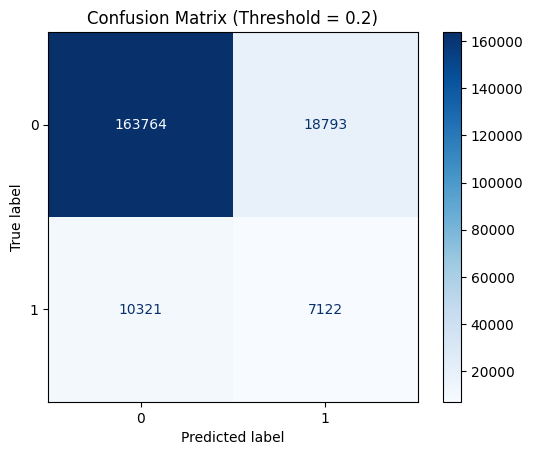

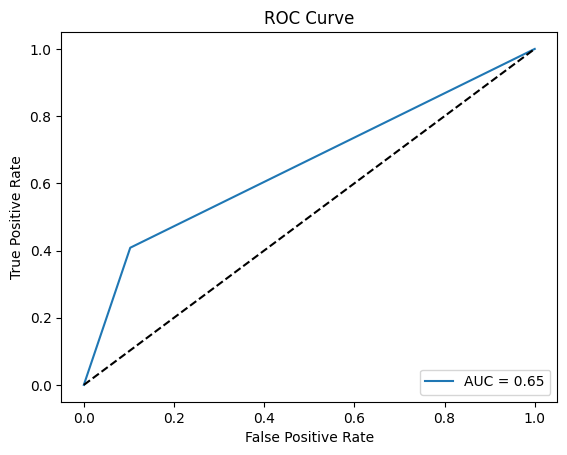

In [57]:
# The model with the choosen treshold

rf_model_proba = RandomForestClassifier(
    n_estimators= 200,
    criterion= 'gini',
    random_state= 42
)
rf_model_proba.fit(X_train, y_train)

# Calculatr probability
y_proba = rf_model_proba.predict_proba(X_test)[:, 1]


threshold= 0.20
y_pred_t = (y_proba >= threshold).astype(int)

precision = precision_score(y_test, y_pred_t) * 100
recall = recall_score(y_test, y_pred_t) * 100
f1 = f1_score(y_test, y_pred_t) * 100

print(f"===== Random Forest | Seuil = {threshold:.2f} =====")
print(f"Precision : {precision:.2f}%")
print(f"Recall    : {recall:.2f}%")
print(f"F1-score  : {f1:.2f}%")

# Matrice de confusion
conf_mat = confusion_matrix(y_test, y_pred_t)
print(conf_mat)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.show()

# Roc-Auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_t)
auc_score = roc_auc_score(y_test, y_pred_t)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [58]:
with mlflow.start_run(run_name="RandomForestModelWithTreshold"):
    # Log Updated Model: RandomForest
    mlflow.log_metrics({
        "f1_score": f1,
        "recall": recall,
        "precision": precision
    })
    mlflow.log_params({
        'n_estimators': 200,
        'criterion': 'gini',
        'random_state': 42,
        'threshold': 0.20
    })
    mlflow.sklearn.log_model(rf_model_proba, "model")

2025/12/22 17:47:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/22 17:47:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# 3)- Comparer avec Decison Tree

In [59]:
decison_tree_model = DecisionTreeClassifier()
decison_tree_model.fit(X_train, y_train)

y_pred = decison_tree_model.predict(X_test)
f1_score_DT = f1_score(y_test, y_pred)
recall_score_DT = recall_score(y_test, y_pred)
precision_score_DT = precision_score(y_test, y_pred)


f1_score:  0.360882259416645
recall :  0.3578512870492461
precison  0.3639650145772595
[[171649  10908]
 [ 11201   6242]]


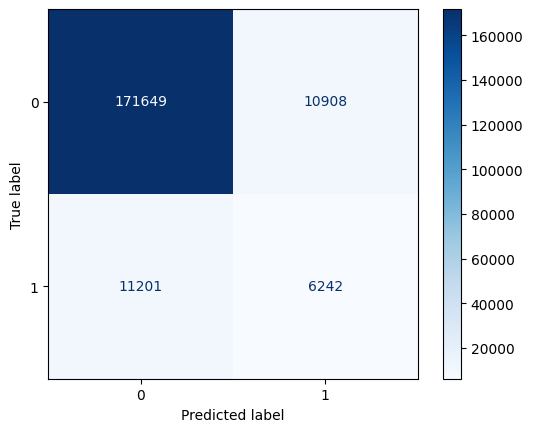

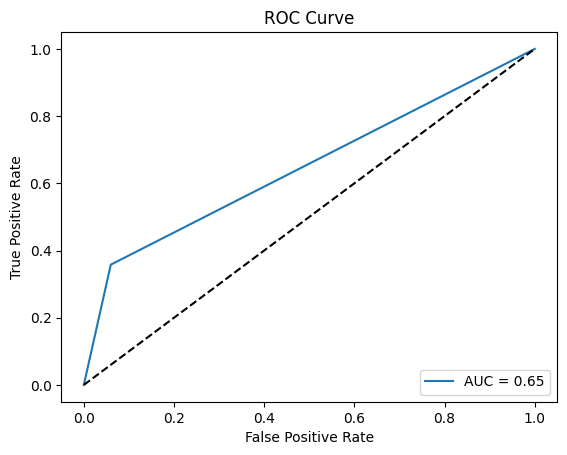

In [60]:
print("f1_score: ",f1_score_DT )
print("recall : ", recall_score_DT)
print("precison ", precision_score_DT )


# Matrice de confusion
conf_mat_DT = confusion_matrix(y_test, y_pred)
print(conf_mat_DT)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_DT)
disp.plot(cmap='Blues', values_format='d')
plt.show()

# Roc-Auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [61]:
# Ajout du modéle dans MLFLOW
with mlflow.start_run(run_name= "DecisonTreeClassifier"):
    mlflow.log_metrics({
            "f1_score": f1_score_DT,
            "recall": recall_score_DT,
            "precision": precision_score_DT
        })
    mlflow.sklearn.log_model(decison_tree_model, "model")
    
    

    

2025/12/22 17:47:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/22 17:47:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# 4)- Comparer avec XGBoost

In [62]:
from xgboost import XGBClassifier
model_xgboost = XGBClassifier()

model_xgboost.fit(X_train, y_train)

y_pred = model_xgboost.predict(X_test)
f1_score_XGB = f1_score(y_test, y_pred)
recall_score_XGB = recall_score(y_test, y_pred)
precision_score_XGB = precision_score(y_test, y_pred)


f1_score:  0.44142945818923474
recall :  0.2853866880697128
precison  0.9739776951672863
[[182424    133]
 [ 12465   4978]]


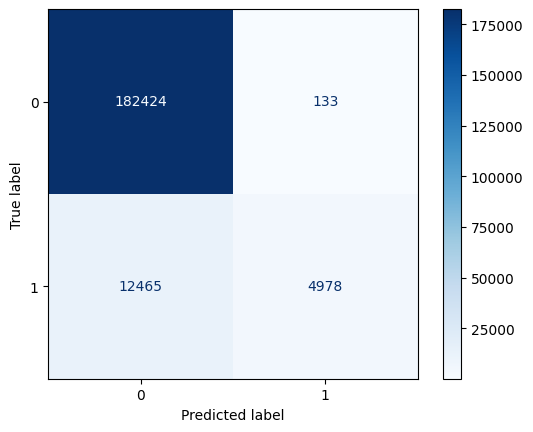

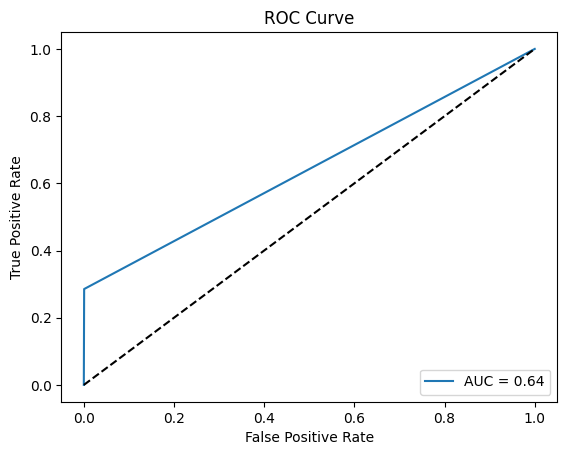

In [63]:
print("f1_score: ",f1_score_XGB)
print("recall : ", recall_score_XGB)
print("precison ", precision_score_XGB )


# Matrice de confusion
conf_mat_XGB = confusion_matrix(y_test, y_pred)
print(conf_mat_XGB)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_XGB)
disp.plot(cmap='Blues', values_format='d')
plt.show()

# Roc-Auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [64]:
with mlflow.start_run(run_name="XGBoostModel"):
    mlflow.log_metrics({
        "f1_score": f1_score_XGB,
        "recall": recall_score_XGB,
        "precision": precision_score_XGB
    })

    mlflow.sklearn.log_model(model_xgboost, "model")

2025/12/22 17:48:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/22 17:48:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# XGBoost with parameters

In [65]:
n_neg = (y_train.values.ravel() == 0).sum()
n_pos = (y_train.values.ravel() == 1).sum()
scale_pos_weight = n_neg / n_pos * 0.5
scale_pos_weight

5.217552887364208

f1_score:  0.24235305565015533
recall :  0.9995413632975979
precison  0.1378936712064411
[[ 73554 109003]
 [     8  17435]]


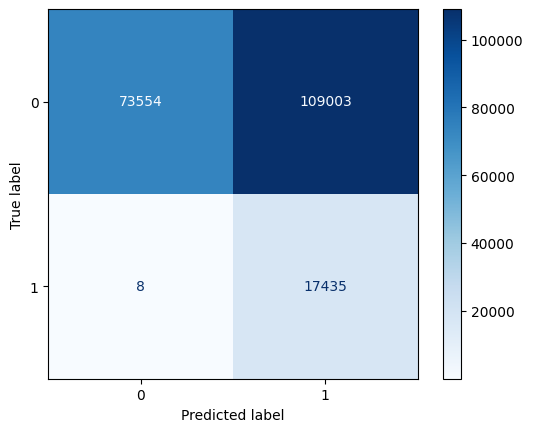

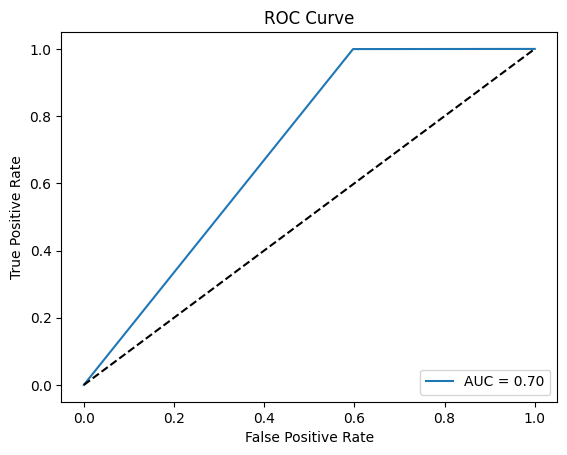

In [66]:
# XGBOOST AMELIORER

model_xgboost = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    eval_metric='aucpr',
    scale_pos_weight= scale_pos_weight,
    random_state=42
)
model_xgboost.fit(X_train, y_train)

y_proba = model_xgboost.predict_proba(X_test)[:, 1]
threshold= 0.20
y_pred = (y_proba >= threshold).astype(int)
f1_score_XGB = f1_score(y_test, y_pred)
recall_score_XGB = recall_score(y_test, y_pred)
precision_score_XGB = precision_score(y_test, y_pred)

print("f1_score: ",f1_score_XGB)
print("recall : ", recall_score_XGB)
print("precison ", precision_score_XGB )


# Matrice de confusion
conf_mat_XGB = confusion_matrix(y_test, y_pred)
print(conf_mat_XGB)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_XGB)
disp.plot(cmap='Blues', values_format='d')
plt.show()


# Roc-Auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



In [68]:
with mlflow.start_run(run_name="XGBoostModelWithParameters"):
    mlflow.log_metrics({
        "f1_score": f1_score_XGB,
        "recall": recall_score_XGB,
        "precision": precision_score_XGB
    })
    mlflow.log_params({
        'n_estimators': 300,
        'max_depth': 4,
        'learning_rate' : 0.05,
        'eval_metric' : 'aucpr',
        'scale_pos_weight' : 'scale_pos_weight',
        'random_state' : 42
    })
    mlflow.sklearn.log_model(model_xgboost, "model")

2025/12/22 17:49:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/22 17:49:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Saving the model with hight performance*


In [77]:
# Model final sauvegardé 
import pickle
with open('C:/Users/hp/Desktop/Credit Card Fraud Detection Project/src/models/final_model.pkl', "wb") as f:
    pickle.dump(rf_model_proba, f)
print("Model is saved successfully")



Model is saved successfully


<h1><center>FIN